# Setup

<div style="background-color: #ffebee; border: 2px solid #d32f2f; padding: 10px; border-radius: 5px; color: #b71c1c;">
        <b>Caution:</b> The setup code below only needs to be run once per assignment. If you've already executed it, you can safely ignore this section and proceed to the <a href="#assignment-content" style="color: #d32f2f; text-decoration: underline;">Assignment Content</a>.
    </div>

This will run through setup of all necessary dependencies to complete the assignment.

## Install required tools

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    # fixing error like "No module named 'imp'"
    !sed -i -e 's/from imp import reload/from importlib import reload/' /usr/local/lib/python3.12/dist-packages/IPython/extensions/autoreload.py
else:
  import os
  # add local dependencies to PATH (for uv installation)
  os.environ['PATH'] = '/usr/local/bin:$HOME/.local/bin:' + os.environ['PATH']
  # add conda dependencies to PATH (for conda installation)
  os.environ['PATH'] = '/opt/anaconda3:~/anaconda3:~:~/miniconda3:/opt/miniconda3:' + os.environ['PATH']

## Install datasets

The code snippets below will mount your Google Drive folder (if in a Colab environment) and proceed to install the relevant datasets needed to complete the assignment.

In [2]:
if IN_COLAB:
    # TODO: For colab, Enter the foldername in your Google Drive
    # to the root of the assignment folder, where this notebook exists
    # e.g. 'XCS231N/XCS231N-A?/src/submission' # you need to update "A?" with the homework number
    FOLDERNAME = 'XCS231N/XCS231N-A3/src/submission'
    WORK_DIR = '/content/drive/MyDrive/{}'.format(FOLDERNAME)
    # This mounts your Google Drive to the Colab VM.
    from google.colab import drive
    drive.mount('/content/drive')

    assert FOLDERNAME is not None, "[!] Enter the foldername."

    # Now that we've mounted your Drive, this ensures that
    # the Python interpreter of the Colab VM can load
    # python files from within it.
    import sys
    sys.path.append(WORK_DIR)
else:
    # on local or azure, FOLDERNAME is set automatically
    FOLDERNAME=os.getcwd()
    WORK_DIR = FOLDERNAME

print(f"FOLDERNAME: ", FOLDERNAME)
print(f"WORK_DIR: ", WORK_DIR)

Mounted at /content/drive
FOLDERNAME:  XCS231N/XCS231N-A3/src/submission
WORK_DIR:  /content/drive/MyDrive/XCS231N/XCS231N-A3/src/submission


In [3]:
print("Getting dataset: START")
%cd $WORK_DIR/xcs231n/datasets
!bash get_datasets.sh
%cd $WORK_DIR
print("Getting dataset: DONE")

Getting dataset: START
/content/drive/MyDrive/XCS231N/XCS231N-A3/src/submission/xcs231n/datasets
Using wget to download datasets...
--2025-11-23 09:09:19--  http://cs231n.stanford.edu/imagenet_val_25.npz
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/imagenet_val_25.npz [following]
--2025-11-23 09:09:19--  https://cs231n.stanford.edu/imagenet_val_25.npz
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3940548 (3.8M)
Saving to: ‘imagenet_val_25.npz.13’

imagenet_val_25.npz 100%[===================>]   3.76M  --.-KB/s    in 0.1s    

2025-11-23 09:09:19 (28.5 MB/s) - ‘imagenet_val_25.npz.13’ saved [3940548/3940548]

/content/drive/MyDrive/XCS231N/XCS231N-A3/src/submission
Getting dataset: DO

# Package Manager Setup

Below you have the option to run through the installation of `uv` package manager. Optionally, you can still work with `conda`.

## `uv` (preferred)

In [ ]:
if not IN_COLAB:
  %cd $WORK_DIR/../..
  !source install.sh -r
  !source .venv/bin/activate

## `conda` (legacy)

In [ ]:
# uncomment to use conda
# if IN_COLAB:
#     !pip install -q condacolab
#     import condacolab
#     condacolab.install()
#     %cd $WORK_DIR/src
#     !conda env create -f environment.yml
#     !exec bash
# else:
#     %cd $WORK_DIR/src
#     !conda env create -f environment.yml

---

<a id="assignment-content"></a>

# Assignment Content

# Image Captioning with Transformers
You have now implemented a vanilla RNN and for the task of image captioning. In this notebook you will implement key pieces of a transformer decoder to accomplish the same task.

**NOTE:** This notebook will be primarily written in PyTorch rather than NumPy, unlike the RNN notebook.

In [4]:
# Setup cell.
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from xcs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from xcs231n.transformer_layers import *
from xcs231n.captioning_solver_transformer import CaptioningSolverTransformer
from xcs231n.classifiers.transformer import CaptioningTransformer
from xcs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from xcs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# COCO Dataset
As in the previous notebooks, we will use the COCO dataset for captioning.

In [5]:
# Load COCO data from disk into a dictionary.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary.
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

base dir  /content/drive/MyDrive/XCS231N/XCS231N-A3/src/submission/xcs231n/datasets/coco_captioning
train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


# Transformer
As you have seen, RNNs are incredibly powerful but often slow to train. Further, RNNs struggle to encode long-range dependencies (though LSTMs are one way of mitigating the issue). In 2017, Vaswani et al introduced the Transformer in their paper ["Attention Is All You Need"](https://arxiv.org/abs/1706.03762) to a) introduce parallelism and b) allow models to learn long-range dependencies. The paper not only led to famous models like BERT and GPT in the natural language processing community, but also an explosion of interest across fields, including vision. While here we introduce the model in the context of image captioning, the idea of attention itself is much more general.



# Transformer: Multi-Headed Attention

### Dot-Product Attention

Recall that attention can be viewed as an operation on a query $q\in\mathbb{R}^d$, a set of value vectors $\{v_1,\dots,v_n\}, v_i\in\mathbb{R}^d$, and a set of key vectors $\{k_1,\dots,k_n\}, k_i \in \mathbb{R}^d$, specified as

\begin{align}
\alpha_i &= \frac{\exp(k_i^\top q)}{\sum_{j=1}^{n} \exp(k_j^\top q)} \\
c &= \sum_{i=1}^{n} v_i \alpha_i \\
\end{align}

where $\alpha_i$ are frequently called the "attention weights", and the output $c\in\mathbb{R}^d$ is a correspondingly weighted average over the value vectors.

### Self-Attention
In Transformers, we perform self-attention, which means that the values, keys and query are derived from the input $X \in \mathbb{R}^{\ell \times d}$, where $\ell$ is our sequence length. Specifically, we learn parameter matrices $V,K,Q \in \mathbb{R}^{d\times d}$ to map our input $X$ as follows:

\begin{align}
v_i = Vx_i\ \ i \in \{1,\dots,\ell\}\\
k_i = Kx_i\ \ i \in \{1,\dots,\ell\}\\
q_i = Qx_i\ \ i \in \{1,\dots,\ell\}
\end{align}

### Multi-Headed Scaled Dot-Product Attention
In the case of multi-headed attention, we learn a parameter matrix for each head, which gives the model more expressivity to attend to different parts of the input. Let $h$ be number of heads, and $Y_i$ be the attention output of head $i$. Thus we learn individual matrices $Q_i$, $K_i$ and $V_i$. To keep our overall computation the same as the single-headed case, we choose $Q_i \in \mathbb{R}^{d\times d/h}$, $K_i \in \mathbb{R}^{d\times d/h}$ and $V_i \in \mathbb{R}^{d\times d/h}$. Adding in a scaling term $\frac{1}{\sqrt{d/h}}$ to our simple dot-product attention above, we have

\begin{equation}
Y_i = \text{softmax}\bigg(\frac{(XQ_i)(XK_i)^\top}{\sqrt{d/h}}\bigg)(XV_i)
\end{equation}

where $Y_i\in\mathbb{R}^{\ell \times d/h}$, where $\ell$ is our sequence length.

In our implementation, we apply dropout to the attention weights (though in practice it could be used at any step):

\begin{equation}
Y_i = \text{dropout}\bigg(\text{softmax}\bigg(\frac{(XQ_i)(XK_i)^\top}{\sqrt{d/h}}\bigg)\bigg)(XV_i)
\end{equation}

Finally, then the output of the self-attention is a linear transformation of the concatenation of the heads:

\begin{equation}
Y = [Y_1;\dots;Y_h]A
\end{equation}

were $A \in\mathbb{R}^{d\times d}$ and $[Y_1;\dots;Y_h]\in\mathbb{R}^{\ell \times d}$.

Implement multi-headed scaled dot-product attention in the `MultiHeadAttention` class in the file `xcs231n/transformer_layers.py`. The code below will check your implementation. The relative error should be less than `e-3`.

In [6]:
torch.manual_seed(231)
np.random.seed(231)


# Choose dimensions such that they are all unique for easier debugging:
# Specifically, the following values correspond to N=1, H=2, T=3, E//H=4, and E=8.
batch_size = 1
sequence_length = 3
embed_dim = 8
attn = MultiHeadAttention(embed_dim, num_heads=2)

# Self-attention.
data = torch.randn(batch_size, sequence_length, embed_dim)
self_attn_output = attn(query=data, key=data, value=data)

# Masked self-attention.
mask = torch.randn(sequence_length, sequence_length) < 0.5
masked_self_attn_output = attn(query=data, key=data, value=data, attn_mask=mask)

# Attention using two inputs.
other_data = torch.randn(batch_size, sequence_length, embed_dim)
attn_output = attn(query=data, key=other_data, value=other_data)

expected_self_attn_output = np.asarray([[[-0.1148,  0.2249,  0.7990, -0.4306, -0.3181,  0.2581, -0.2803,
          -0.3003],
         [-0.1997,  0.1746,  0.7377, -0.3549, -0.2657,  0.2693, -0.2541,
          -0.2476],
         [-0.1645,  0.1524,  0.6942, -0.2624, -0.3221,  0.1781, -0.3361,
          -0.1662]]])

expected_masked_self_attn_output = np.asarray([[[-0.1347,  0.1934,  0.8628, -0.4903, -0.2614,  0.2798, -0.2586,
          -0.3019],
         [-0.5323, -0.0602,  0.6767, -0.3014,  0.2449,  0.4311,  0.0079,
          -0.1761],
         [-0.1183,  0.2395,  0.7118, -0.2996, -0.5005,  0.1880, -0.3792,
          -0.2138]]])


expected_attn_output = np.asarray(
  [[[ 0.1660,  0.3670,  0.2343, -0.4003, -0.0822,  0.1100, -0.4037,
          -0.1459],
         [ 0.2094,  0.3884,  0.4454, -0.4709, -0.1731,  0.0913, -0.4181,
          -0.2077],
         [ 0.1936,  0.2913,  0.4173, -0.4385, -0.1120,  0.0736, -0.4017,
          -0.1803]]])


print('self_attn_output error: ', rel_error(expected_self_attn_output, self_attn_output.detach().numpy()))
print('masked_self_attn_output error: ', rel_error(expected_masked_self_attn_output, masked_self_attn_output.detach().numpy()))
print('attn_output error: ', rel_error(expected_attn_output, attn_output.detach().numpy()))

self_attn_output error:  0.0001394257078806217
masked_self_attn_output error:  0.0020874306110103586
attn_output error:  0.00019326292075244386


# Positional Encoding

While transformers are able to easily attend to any part of their input, the attention mechanism has no concept of token order. However, for many tasks (especially natural language processing), relative token order is very important. To recover this, the authors add a positional encoding to the embeddings of individual word tokens.

Let us define a matrix $P \in \mathbb{R}^{l\times d}$, where $P_{ij} = $

$$
\begin{cases}
\text{sin}\left(i \cdot 10000^{-\frac{j}{d}}\right) & \text{if j is even} \\
\text{cos}\left(i \cdot 10000^{-\frac{(j-1)}{d}}\right) & \text{otherwise} \\
\end{cases}
$$

Rather than directly passing an input $X \in \mathbb{R}^{l\times d}$ to our network, we instead pass $X + P$.

Implement this layer in `PositionalEncoding` in `xcs231n/transformer_layers.py`. Once you are done, run the following to perform a simple test of your implementation. You should see errors on the order of `e-3` or less.

In [7]:
torch.manual_seed(231)
np.random.seed(231)

batch_size = 1
sequence_length = 2
embed_dim = 6
data = torch.randn(batch_size, sequence_length, embed_dim)

pos_encoder = PositionalEncoding(embed_dim)
output = pos_encoder(data)

expected_pe_output = np.asarray([[[-1.234,  1.113,  1.698, -0.086, -0.774,  1.273],
         [ 0.903, -0.478,  0.553,  0.813,  1.264,  1.703]]])

print('pe_output error: ', rel_error(expected_pe_output, output.detach().numpy()))

pe_output error:  0.002794341454942572


# Inline Question 1

Several key design decisions were made in designing the scaled dot product attention we introduced above. Explain why the following choices were beneficial:
1. Using multiple attention heads as opposed to one.
2. Dividing by $\sqrt{d/h}$ before applying the softmax function. Recall that $d$ is the feature dimension and $h$ is the number of heads.
3. Adding a linear transformation to the output of the attention operation.

Only one or two sentences per choice is necessary, but be sure to be specific in addressing what would have happened without each given implementation detail, why such a situation would be suboptimal, and how the proposed implementation improves the situation.

**Your Answer:**
### START ANSWER HERE ###
1. Multiple head allows the model to focus on different aspects of the input simultaneously, improving expressiveness and learning richer representations. Without it, the model would be forced to attend to all features in the same representation subspace.

2. Dividing by √(d/h) normalizes the magnitude, keeping gradients stable and enabling effective training. Without it, the gradients would get eventually get extremely small and learning would be slow.

3. The linear transformation allows the model to recombine the multi-head outputs into a coherent, learnable representation. Without it, concatenating multiple heads would produce a mismatched representation dimension, reducing flexibility in combining information.
### END ANSWER HERE ###

# Transformer Decoder Block

The Transformer decoder layer consists of three main components: (1) a self-attention module that processes the input sequence of vectors, (2) a cross-attention module that incorporates additional context (e.g., image features in our case), and (3) a feedforward module that independently processes each vector in the sequence. Complete the implementation of `TransformerDecoderLayer` in `xcs231n/transformer_layers.py` and test it below. The relative error should be less than 1e-6.

In [8]:
torch.manual_seed(231)
np.random.seed(231)

N, T, TM, D = 1, 4, 5, 12

decoder_layer = TransformerDecoderLayer(D, 2, 4*D)
tgt = torch.randn(N, T, D)
memory = torch.randn(N, TM, D)
tgt_mask = torch.randn(T, T) < 0.5

output = decoder_layer(tgt, memory, tgt_mask)


expected_output = np.asarray(
[[[ 0.7973989,  0.1705188,  0.5952847, -0.3850437,  0.6473090,
          -1.7973099, -0.0188924, -1.8536081, -0.8088982,  0.5204701,
           1.5894681,  0.5433026],
         [-0.8064482,  0.3082525,  0.0128748, -0.1249493,  0.8575743,
          -0.8817163,  0.4579798, -1.3449310,  2.2701468, -0.9864848,
           0.9998496, -0.7621486],
         [-1.1444300,  0.7568803,  0.2958311, -0.1750616,  1.7544298,
          -0.8148872,  0.8621378, -0.7340645,  1.1998730, -1.7980157,
           0.2740493, -0.4767423],
         [-0.6067719,  0.3904864, -0.2153541, -0.8682908,  0.1589641,
           0.1644578,  0.4389339, -1.3275373,  1.2310632,  1.2271752,
           1.3578585, -1.9509850]]]
)
print('error: ', rel_error(expected_output, output.detach().numpy()))

error:  9.8507110334607e-07


# Transformer for Image Captioning
Now that you have implemented the previous layers, you can combine them to build a Transformer-based image captioning model. Open the file `xcs231n/classifiers/transformer.py` and look at the `CaptioningTransformer` class.

Implement the `forward` function of the class. After doing so, run the following to check your forward pass using a small test case; you should see error on the order of `e-5` or less.

In [9]:
torch.manual_seed(231)
np.random.seed(231)

N, D, W = 4, 20, 30
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 3

transformer = CaptioningTransformer(
    word_to_idx,
    input_dim=D,
    wordvec_dim=W,
    num_heads=2,
    num_layers=2,
    max_length=30
)

features = torch.randn(N, D)
captions = torch.randint(0, V, (N, T))

scores = transformer(features, captions)

expected_scores = np.asarray(
[[[ 0.75886, -0.69655, -0.95691],
         [ 0.64593, -0.44269, -1.61055],
         [ 0.78522, -0.91518, -0.43513]],

        [[ 0.50102, -0.51465, -0.79957],
         [ 0.55627, -0.79746, -1.10802],
         [ 0.61483, -0.79027, -1.22522]],

        [[ 0.54926, -0.53859, -1.67718],
         [ 0.63181, -0.35069, -1.16072],
         [ 0.13742, -1.03246, -1.28366]],

        [[ 0.81889, -0.40008, -0.81413],
         [ 0.71647, -0.97332, -1.54536],
         [ 0.29304, -0.54018, -1.08682]]]
)

print('scores error: ', rel_error(expected_scores, scores.detach().numpy()))

scores error:  1.7994987260479932e-05


# Overfit Transformer Captioning Model on Small Data
Run the following to overfit the Transformer-based captioning model on the same small dataset as we used for the RNN previously.

base dir  /content/drive/MyDrive/XCS231N/XCS231N-A3/src/submission/xcs231n/datasets/coco_captioning
(Iteration 1 / 200) loss: 5.045327
(Iteration 11 / 200) loss: 2.808727
(Iteration 21 / 200) loss: 2.022354
(Iteration 31 / 200) loss: 1.670440
(Iteration 41 / 200) loss: 1.330231
(Iteration 51 / 200) loss: 1.236568
(Iteration 61 / 200) loss: 0.843831
(Iteration 71 / 200) loss: 0.702294
(Iteration 81 / 200) loss: 0.516776
(Iteration 91 / 200) loss: 0.438581
(Iteration 101 / 200) loss: 0.376332
(Iteration 111 / 200) loss: 0.153824
(Iteration 121 / 200) loss: 0.139354
(Iteration 131 / 200) loss: 0.104465
(Iteration 141 / 200) loss: 0.084864
(Iteration 151 / 200) loss: 0.087971
(Iteration 161 / 200) loss: 0.053218
(Iteration 171 / 200) loss: 0.046330
(Iteration 181 / 200) loss: 0.043136
(Iteration 191 / 200) loss: 0.027111


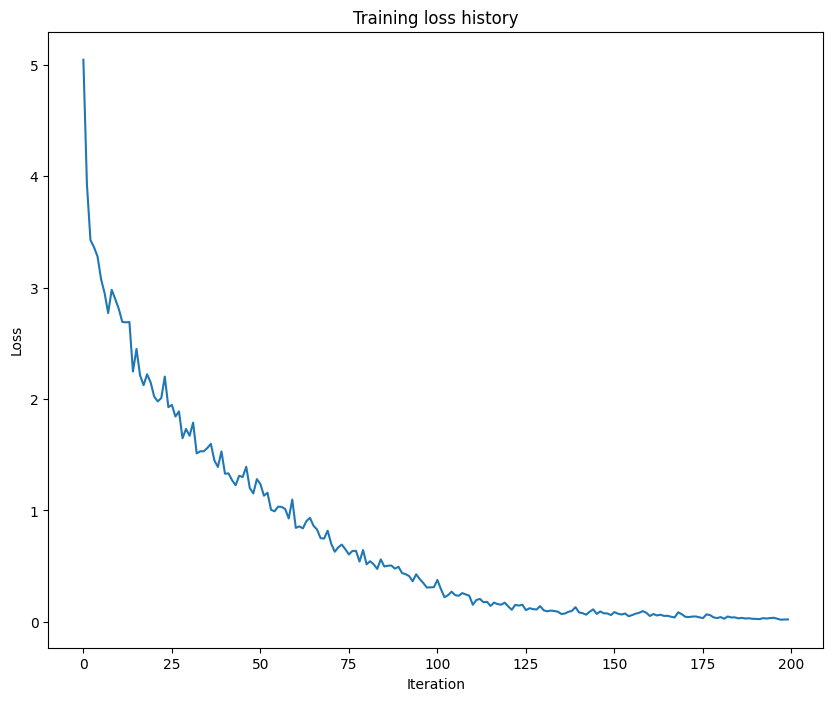

In [10]:
torch.manual_seed(231)
np.random.seed(231)

data = load_coco_data(max_train=50)

transformer = CaptioningTransformer(
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          wordvec_dim=256,
          num_heads=2,
          num_layers=2,
          max_length=30
        )


transformer_solver = CaptioningSolverTransformer(transformer, data, idx_to_word=data['idx_to_word'],
           num_epochs=100,
           batch_size=25,
           learning_rate=0.001,
           verbose=True, print_every=10,
         )

transformer_solver.train()

# Plot the training losses.
plt.plot(transformer_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

Print final training loss. You should see a final loss of less than 0.05 .

In [11]:
print('Final loss: ', transformer_solver.loss_history[-1])

Final loss:  0.02236586


# Transformer Sampling at Test Time
The sampling code has been written for you. You can simply run the following to compare with the previous results with the RNN. As before the training results should be much better than the validation set results, given how little data we trained on.

URL Error:  Gone http://farm1.staticflickr.com/202/487987371_489a65d670_z.jpg


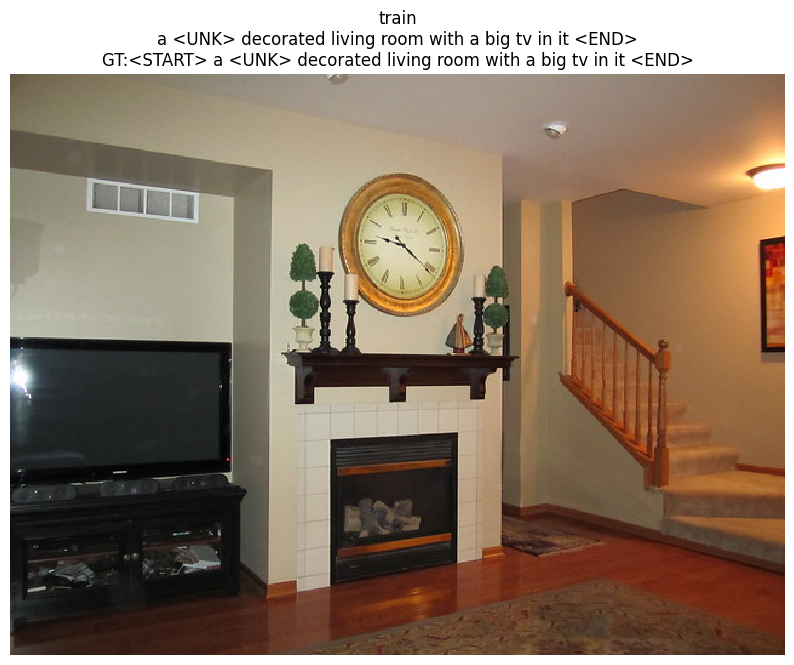

URL Error:  Gone http://farm1.staticflickr.com/25/44101107_9491d72776_z.jpg


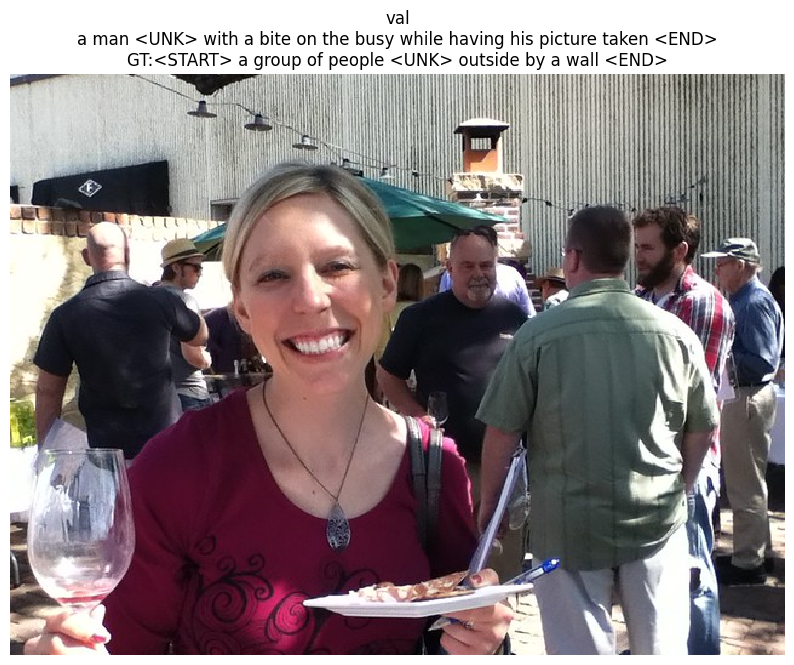

In [12]:
# If you get an error, the URL just no longer exists, so don't worry!
# You can re-sample as many times as you want.
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = transformer.sample(features, max_length=30)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        img = image_from_url(url)
        # Skip missing URLs.
        if img is None: continue
        plt.imshow(img)
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

# Vision Transformer (ViT)

[Dosovitskiy et. al.](https://arxiv.org/abs/2010.11929) showed that applying a transformer model on a sequence of image patches (referred to as Vision Transformer) not only achieves impressive performance but also scales more effectively than convolutional neural networks when trained on large datasets. We will build a version of Vision Transformer using our existing implementation of transformer components and train it on the CIFAR-10 dataset.

Vision Transformer converts input image into a sequence of patches of fixed size and embed each patch into a latent vector. In `xcs231n/transformer_layers.py`, complete the implementation of `PatchEmbedding` and test it below. You should see relative error less than 1e-4.

In [13]:
from xcs231n.transformer_layers import PatchEmbedding

torch.manual_seed(231)
np.random.seed(231)

N = 2
HW = 16
PS = 8
D = 8

patch_embedding = PatchEmbedding(
    img_size=HW,
    patch_size=PS,
    embed_dim=D
)

x = torch.randn(N, 3, HW, HW)
output = patch_embedding(x)

expected_output = np.asarray([
        [[-0.6312704 ,  0.02531429,  0.6112642 , -0.49089882,
          0.01412961, -0.6959372 , -0.32862484, -0.45402682],
        [ 0.18816411, -0.08142513, -0.9829535 , -0.23975623,
         -0.23109074,  0.97950286, -0.40997326,  0.7457837 ],
        [ 0.01810865,  0.15780598, -0.91804236,  0.36185235,
          0.8379501 ,  1.0191797 , -0.29667392,  0.20322265],
        [-0.18697818, -0.45137224, -0.40339014, -1.4381214 ,
         -0.43450755,  0.7651071 , -0.83683825, -0.16360264]],

       [[-0.39786366,  0.16201034, -0.19008337, -1.0602452 ,
         -0.28693503,  0.09791763,  0.26614824,  0.41781986],
        [ 0.35146567, -0.4469593 , -0.1841726 ,  0.45757473,
         -0.61304873, -0.29104248, -0.16124889, -0.14987172],
        [-0.2996967 ,  0.27353522, -0.09929767,  0.01973832,
         -1.2312065 , -0.6374332 , -0.22963578,  0.55696607],
        [-0.93818814,  0.02465284, -0.21117875,  1.1860403 ,
         -0.06137538, -0.21062079, -0.094347  ,  0.50032747]]])

print('error: ', rel_error(expected_output, output.detach().numpy()))

error:  9.182286955268188e-08


The sequence of patch vectors is processed by transformer encoder layers, each consisting of a self-attention and a feed-forward module. Since all vectors attend to one another, attention masking is not strictly necessary. However, we still implement it for the sake of consistency.

Implement `TransformerEncoderLayer` in `xcs231n/transformer_layers.py` and test it below. You should see relative error less than 1e-6.


In [14]:
torch.manual_seed(231)
np.random.seed(231)

from xcs231n.transformer_layers import TransformerEncoderLayer

N, T, TM, D = 1, 4, 5, 12

encoder_layer = TransformerEncoderLayer(D, 2, 4*D)
x = torch.randn(N, T, D)
x_mask = torch.randn(T, T) < 0.5

output = encoder_layer(x, x_mask)

expected_output = np.asarray(
[[[-0.468097, -0.209465,  0.574843, -1.007282,  1.386149,  0.235459,
           0.942292, -0.572514, -1.704719, -1.222015,  1.617727,  0.427621],
         [-0.162546,  1.103722, -1.028051, -0.307341, -2.160513,  1.275178,
          -0.022269, -0.924952,  1.417923, -0.112859,  0.406233,  0.515477],
         [ 0.255601,  1.003893, -1.254898,  0.917847, -1.967772, -0.233367,
          -0.524232, -0.234828,  0.190839,  2.015347,  0.181081, -0.349513],
         [-0.765535,  0.600895, -0.538682, -1.519948,  1.226579,  0.481148,
           0.707173,  0.555546, -1.374603, -1.377802,  0.768860,  1.236369]]]
)

print('error: ', rel_error(expected_output, output.detach().numpy()))

error:  7.262693858319159e-06


Take a look at the `VisionTransformer` implementation in `xcs231n/classifiers/transformer.py`.

For classification, ViT divides the input image into patches and processes the sequence of patch vectors using a transformer. Finally, all the patch vectors are average-pooled and used to predict the image class. We will use the same 1D sinusoidal positional encoding to inject ordering information, though 2D sinusoidal and learned positional encodings are also valid choices.

Complete the ViT forward pass and test it below. You should see relative error less than 1e-6.

In [15]:
torch.manual_seed(231)
np.random.seed(231)
from xcs231n.classifiers.transformer import VisionTransformer

imgs = torch.randn(3, 3, 32, 32)
transformer = VisionTransformer()
scores = transformer(imgs)
expected_scores = np.asarray(
[[-0.158277,  0.122878, -0.026341, -0.180966, -0.071095, -0.064299,
          0.148130,  0.035577,  0.200194,  0.099250],
        [-0.097436,  0.181270, -0.060364, -0.089896, -0.105121, -0.092695,
          0.162580,  0.045888,  0.147600,  0.097863],
        [-0.087285,  0.207854, -0.039861, -0.109968, -0.133690, -0.103884,
          0.145094,  0.052029,  0.148208,  0.103894]]
)
print('scores error: ', rel_error(expected_scores, scores.detach().numpy()))

scores error:  4.919867545310672e-06



We will first verify our implementation by overfitting it on one training batch. Tune learning rate and weight decay accordingly.

In [16]:
from torchvision import transforms
from torchvision.datasets import CIFAR10
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

train_data = CIFAR10(root='data', train=True, transform=transforms.ToTensor(), download=True)
test_data = CIFAR10(root='data', train=False, transform=transforms.ToTensor(), download=True)

In [17]:
learning_rate = 1e-4  # Experiment with this
weight_decay = 1.e-4  # Experiment with this

# ### START CODE HERE ###
learning_rate = 1e-3
weight_decay = 0.0
# ### END CODE HERE ###

batch = next(iter(DataLoader(train_data, batch_size=64, shuffle=False)))
model = VisionTransformer(dropout=0.0)
loss_criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
model.train()

epochs = 100
for epoch in range(epochs):
    imgs, target = batch
    out = model(imgs)
    loss = loss_criterion(out, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    top1 = (out.argmax(-1) == target).float().mean().item()
    if epoch % 10 == 0:
      print(f"[{epoch}/{epochs}] Loss {loss.item():.6f}, Top-1 Accuracy: {top1:.3f}")

[0/100] Loss 2.332251, Top-1 Accuracy: 0.078
[10/100] Loss 2.106962, Top-1 Accuracy: 0.188
[20/100] Loss 1.963382, Top-1 Accuracy: 0.250
[30/100] Loss 1.681456, Top-1 Accuracy: 0.375
[40/100] Loss 1.390456, Top-1 Accuracy: 0.547
[50/100] Loss 1.000869, Top-1 Accuracy: 0.688
[60/100] Loss 0.554108, Top-1 Accuracy: 0.859
[70/100] Loss 0.198858, Top-1 Accuracy: 1.000
[80/100] Loss 0.256899, Top-1 Accuracy: 0.922
[90/100] Loss 0.149063, Top-1 Accuracy: 0.969


In [18]:
# You should get perfect 1.00 accuracy
print(f"Overfitting ViT on one batch. Top-1 accuracy: {top1}")

Overfitting ViT on one batch. Top-1 accuracy: 1.0


Now we will train it on the entire dataset.

In [19]:
from xcs231n.classification_solver_vit import ClassificationSolverViT

############################################################################
# TODO: Train a Vision Transformer model that achieves over 0.45 test      #
# accuracy on CIFAR-10 after 2 epochs by adjusting the model architecture  #
# and/or training parameters as needed.                                    #
#                                                                          #
# Note: If you want to use a GPU runtime, go to `Runtime > Change runtime  #
# type` and set `Hardware accelerator` to `GPU`. This will reset Colab,    #
# so make sure to rerun the entire notebook from the beginning afterward.  #
############################################################################


learning_rate = 1e-4
weight_decay = 0.0
batch_size = 64
model = VisionTransformer()  # You may want to change the default params.


# ### START CODE HERE ###
learning_rate = 3e-4  # slightly higher for faster convergence
weight_decay = 0.0
batch_size = 64

model = VisionTransformer(
    img_size=32,
    patch_size=4,
    in_channels=3,
    embed_dim=256,
    num_layers=6,
    num_heads=8,
    dim_feedforward=512,
    num_classes=10,
    dropout=0.1
)

# ### END CODE HERE ###

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

solver = ClassificationSolverViT(
    train_data=train_data,
    test_data=test_data,
    model=model,
    num_epochs = 2,  # Don't change this
    learning_rate = learning_rate,
    weight_decay = weight_decay,
    batch_size = batch_size,
)

solver.train('cuda' if torch.cuda.is_available() else 'cpu')

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

In [20]:
print(f"Accuracy on test set: {solver.results['best_test_acc']}")

Accuracy on test set: 0.5059


# Inline Question 2

Despite their recent success in large-scale image recognition tasks, ViTs often lag behind traditional CNNs when trained on smaller datasets. What underlying factor contribute to this performance gap? What techniques can be used to improve the performance of ViTs on small datasets?

**Your Answer**:

### START ANSWER HERE ###
ViTs perform worse than CNNs on small datasets because they lack CNNs’ built-in inductive biases like locality and translation equivariance, making them prone to overfitting. Their performance can be improved through techniques such as data augmentation, pretraining on large datasets followed by fine-tuning, regularization methods, or using hybrid CNN–Transformer architectures.
### END ANSWER HERE ###


# Inline Question 3

How does the computational cost of the self-attention layers in a ViT change if we independently make the following changes?

(i) Double the hidden dimension.
(ii) Double the height and width of the input image.
(iii) Double the patch size.
(iv) Double the number of layers.

**Your Answer**:

### START ANSWER HERE ###
(i) Doubling the hidden dimension increases the size of Q, K, V matrices and the final projection, which scales quadratically with 𝑑. This results in roughly 4× higher computation.

(ii) Doubling image height and width increases the number of tokens by 4×, and self-attention scales quadratically with token count. This leads to roughly 16× higher computation.

(iii) Doubling the patch size reduces the number of tokens by 4×. This reduces computation by roughly 16×.

(iv) Self-attention cost is linear in the number of layers, so doubling layers simply doubles the computation.
### END ANSWER HERE ###


# Submission

**You will need to submit the answers from this notebook on Gradescope.**